<a href="https://colab.research.google.com/github/sokharsamb/CNN_exercises_MNIST/blob/master/Exercise/cifar_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms



In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [406]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# 1. Network **Architecture**

*   List item
*   List item

# Cat and dog classification

In [541]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
#Load test data 
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


train_target = torch.utils.data.DataLoader(train_loader, batch_size=4,
                                          shuffle=True, num_workers=2)
test_target = torch.utils.data.DataLoader(test_loader, batch_size=4,
                                          shuffle=True, num_workers=2)




0it [00:00, ?it/s]

170500096it [00:02, 73459172.83it/s]                               


Extracting ./files/cifar-10-python.tar.gz to ./files/
Files already downloaded and verified


torch.Size([64, 3, 32, 32])


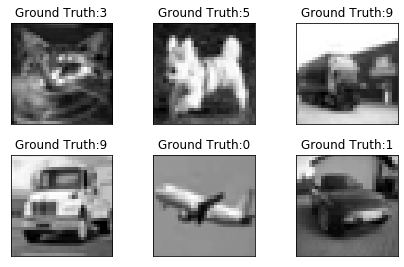

In [542]:

example=enumerate(train_loader)
batch_index,(example_data,example_target)=next(example)
print(example_data.shape)

fig=plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}".format(example_target[i]))
    plt.xticks([])
    plt.yticks([])
    fig

In [0]:
class TopoNet(nn.Module):
  def __init__(self):
    super(TopoNet, self).__init__()
    self.conv1=nn.Conv2d(3,10,kernel_size=3, stride=2)
    self.conv2=nn.Conv2d(10,20,kernel_size=3,stride=2)
    self.conv3=nn.Conv2d(20,20,kernel_size=3,stride=2)
    self.conv4=nn.Conv2d(20,320,kernel_size=3,stride=2)
    self.fc1=nn.Linear(20,10)
    self.fc2=nn.Linear(10,10)
    self.conv2_drop=nn.Dropout2d()
    self.conv4_drop=nn.Dropout2d()


  def forward(self,x):
      x=F.relu(F.max_pool2d(self.conv1(x),2))
      x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
      #x=F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)),2))
      x=x.view(-1,20)
      x=F.relu(self.fc1(x))
      x=self.fc2(x)
      return F.log_softmax(x)


In [0]:
network=TopoNet()
optimizer=optim.SGD(network.parameters(),lr=0.1,momentum=0.5)#stochastic optimizer

In [545]:
network.modules

<bound method Module.modules of TopoNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2))
  (conv4): Conv2d(20, 320, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv4_drop): Dropout2d(p=0.5, inplace=False)
)>

In [0]:
train_losses=[]
test_losses=[]
train_counter=[]
test_counter=[i*len(train_loader.dataset) for i in range(n_epochs+1)]
criterion = nn.CrossEntropyLoss()


In [0]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        print(output.shape, target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), './model.pth')
        torch.save(optimizer.state_dict(), './optimizer.pth')

In [0]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            #print(data.shape)
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_counter.append((data*1000) + ((data-1)*len(test_loader.dataset)))
    torch.save(network.state_dict(), './model.pth')
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return correct

In [549]:
test()
for epoch in range(1,n_epochs+1):
    train(epoch)
    a=test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3211, Accuracy: 1008/10000 (10%)

torch.Size([64, 10]) torch.Size([64])
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.347716
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.310603
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.298707
torc